# Using an evaluation cascade for economic evaluation of noisy functions
We demonstrate here how picking the best performing function from a set of candidates is typically suboptimal due to the noise in the evaluation, and how this can be mitigated using an evaluation cascade and the probability of dominance. Although in the paper this is demonstrated for functions defined by agentic scaffolds being evaluated on math problems, the same principles are relevant whenever an evaluation is sufficiently noisy. The demonstration here uses a simple setup where the functions are gaussians with different variances and means.

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# fix random seed
np.random.seed(0)

Let's assume the functions $f_i$ are gaussians with a variance of $\sigma_i^2$ and means $\mu_i$, where the $\mu_i$ are drawn from a uniform distribution between 20 and 35 and the $\sigma_i$ from a uniform distribution between 5 and 10. We want to pick the best performing function, which is often done by picking the one with the highest mean. However, we can only sample from the $f$s and pick based on the empirical samples. Let's say we have 100 functions and take 3 samples from each:

In [3]:
mean_lower, mean_upper = 20, 35
std_lower, std_upper = 5, 10
n_funcs = 50
samples_per_func = 3

mu_i = np.random.uniform(mean_lower, mean_upper, n_funcs)
sigma_i = np.random.uniform(std_lower, std_upper, n_funcs)

estimated_mu_i = np.array([np.random.normal(mu_i[j], sigma_i[j], samples_per_func).mean()
                           for j in range(n_funcs)])

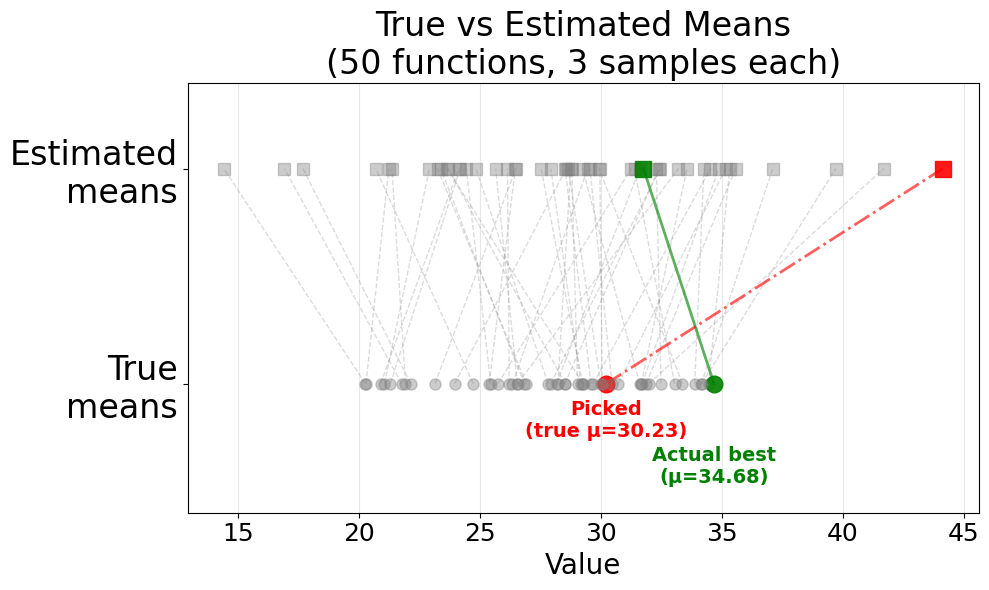

In [4]:
# plot the estimated means and the true means
fig, ax = plt.subplots(figsize=(10, 6))

# Identify the best indices
best_estimated_idx = estimated_mu_i.argmax()
true_best_idx = mu_i.argmax()

lines = {true_best_idx: '-', best_estimated_idx: '-.'}

# Plot each function's true and estimated mean
for i, (mu, est_mu) in enumerate(zip(mu_i, estimated_mu_i)):
    # Determine color: use specific colors for best functions, gray for others
    if i == true_best_idx:
        color = 'green'
        alpha = 0.9
        markersize = 12
        linewidth = 2
    elif i == best_estimated_idx:
        color = 'red'
        alpha = 0.9
        markersize = 12
        linewidth = 2
    else:
        color = 'gray'
        alpha = 0.4
        markersize = 8
        linewidth = 1

    # Plot a marker at the true mean
    ax.plot(mu, 1, 'o', color=color, markersize=markersize, alpha=alpha, label='True mean' if i == 0 else '')

    # Plot the estimated mean above
    ax.plot(est_mu, 1.5, 's', color=color, markersize=markersize, alpha=alpha, label='Estimated mean' if i == 0 else '')

    # Draw a line connecting true mean to estimated mean
    ax.plot([mu, est_mu], [1, 1.5], lines.get(i, '--'), color=color, alpha=alpha * 0.7, linewidth=linewidth)

# Add labels for the highlighted functions
ax.text(mu_i[true_best_idx], 0.77, f'Actual best\n(μ={mu_i[true_best_idx]:.2f})',
        ha='center', fontsize=14, color='green', fontweight='bold')
ax.text(mu_i[best_estimated_idx], 0.875, f'Picked\n(true μ={mu_i[best_estimated_idx]:.2f})',
        ha='center', fontsize=14, color='red', fontweight='bold')

ax.set_xlabel('Value', fontsize=20)
plt.xticks(fontsize=18)
ax.set_ylim(0.7, 1.7)
ax.set_yticks([1, 1.5])
ax.set_yticklabels(['True\nmeans', 'Estimated\nmeans'], fontsize=24)
ax.set_title(f'True vs Estimated Means\n({n_funcs} functions, {samples_per_func} samples each)',
             fontsize=24)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [5]:
print(f'Best true mean: {mu_i.max():.2f}, Best estimated mean: {estimated_mu_i.max():.2f}')
print(f"Best estimated mean's actual mean: {mu_i[estimated_mu_i.argmax()]:.2f}")

Best true mean: 34.68, Best estimated mean: 44.13
Best estimated mean's actual mean: 30.23


As we can see, a suboptimal function is often picked because of the noise. Although re-evaluating all the functions is costly, it is enough to only look at the top few (say 20%), as only the best function is of interest. To reduce the noise, let's re-evaluate them using 10 samples instead of 3.

In [6]:
samples_per_func = 10
top_perc = 0.2
n_top = int(n_funcs * top_perc)
top_indices = np.argsort(estimated_mu_i)[-n_top:]

re_estimated_samples = np.array([
    np.random.normal(mu_i[i], sigma_i[i], samples_per_func)
    for i in top_indices
])

re_estimated_mu_i = np.array([samples.mean() for samples in re_estimated_samples])

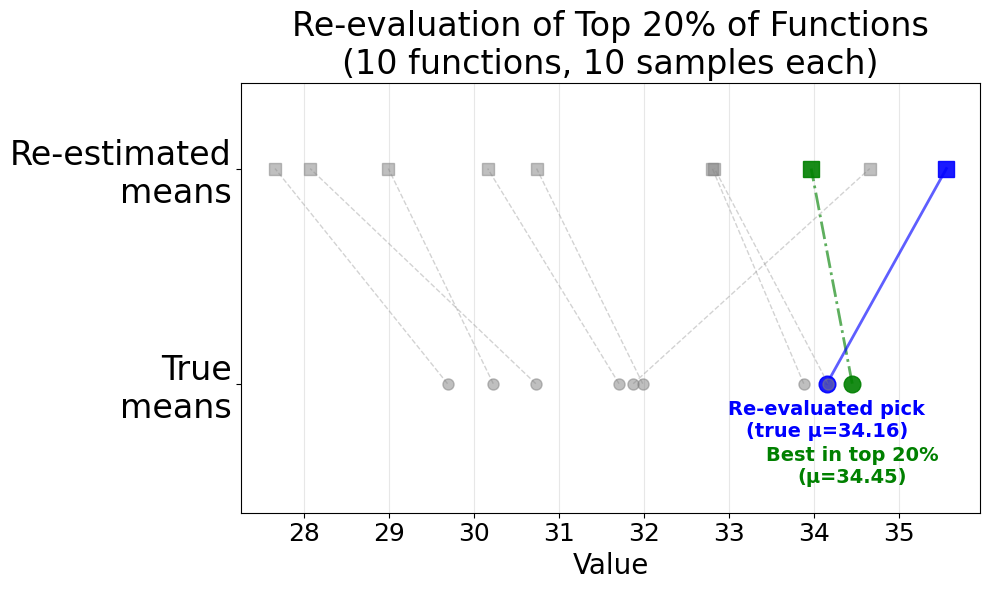

In [7]:
# plot of the re-evaluated means
fig, ax = plt.subplots(figsize=(10, 6))

# Identify the best indices
best_reestimated_idx = re_estimated_mu_i.argmax()
true_best_in_top_idx = mu_i[top_indices].argmax()
global_true_best_idx = mu_i.argmax()

# Plot each top function's true and re-estimated mean
for idx, (top_i, re_est_mu) in enumerate(zip(top_indices, re_estimated_mu_i)):
    mu = mu_i[top_i]

    # Determine color and style
    if idx == best_reestimated_idx:
        color = 'blue'
        alpha = 0.9
        markersize = 12
        linewidth = 2
        linestyle = '-'
    elif idx == true_best_in_top_idx:
        color = 'green'
        alpha = 0.9
        markersize = 12
        linewidth = 2
        linestyle = '-.'
    else:
        color = 'gray'
        alpha = 0.5
        markersize = 8
        linewidth = 1
        linestyle = '--'

    # Plot markers
    ax.plot(mu, 1, 'o', color=color, markersize=markersize, alpha=alpha)
    ax.plot(re_est_mu, 1.5, 's', color=color, markersize=markersize, alpha=alpha)
    ax.plot([mu, re_est_mu], [1, 1.5], linestyle, color=color, alpha=alpha * 0.7, linewidth=linewidth)

# Add labels
ax.text(mu_i[top_indices[true_best_in_top_idx]], 0.77,
        f'Best in top {int(top_perc * 100)}%\n(μ={mu_i[top_indices[true_best_in_top_idx]]:.2f})',
        ha='center', fontsize=14, color='green', fontweight='bold')
ax.text(mu_i[top_indices[best_reestimated_idx]], 0.875,
        f'Re-evaluated pick\n(true μ={mu_i[top_indices[best_reestimated_idx]]:.2f})',
        ha='center', fontsize=14, color='blue', fontweight='bold')

ax.set_xlabel('Value', fontsize=20)
plt.xticks(fontsize=18)
ax.set_ylim(0.7, 1.7)
ax.set_yticks([1, 1.5])
ax.set_yticklabels(['True\nmeans', 'Re-estimated\nmeans'], fontsize=24)
ax.set_title(
    f'Re-evaluation of Top {int(top_perc * 100)}% of Functions\n({n_top} functions, {samples_per_func} samples each)',
    fontsize=24)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

The independent re-evaluation often gives the function with the actual highest mean or at least one closer to it. However, as different functions have a different variance, the one with the highest mean isn't necessarily the one that would typically perform best. This can be seen by observing the empirical distribution of the top-3 functions:

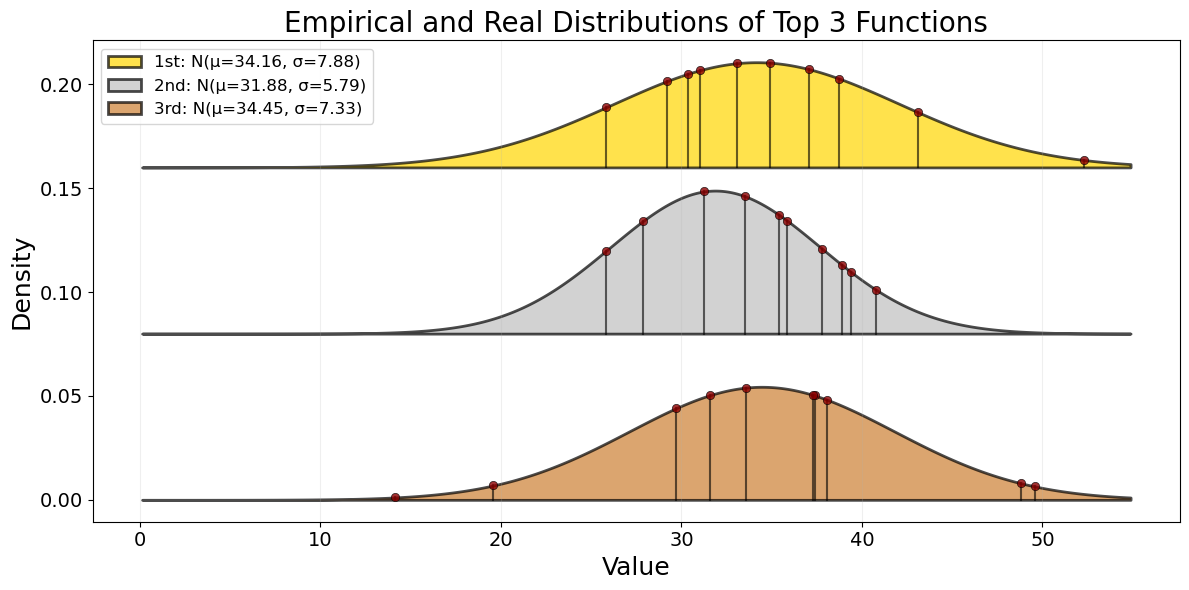

In [8]:
n_plot = 3
top_3_indices = top_indices[np.argsort(re_estimated_mu_i)[-n_plot:]]

fig, ax = plt.subplots(figsize=(12, 6))

max_sigma = sigma_i.max()
x = np.linspace(mean_lower - 2 * max_sigma, mean_upper + 2 * max_sigma, 1000)
colors = ['gold', 'silver', '#CD7F32']  # Gold, Silver, Bronze
labels = ['1st', '2nd', '3rd']

# Plot in reverse order so best is on top
for rank, (idx, color, label) in enumerate(zip(reversed(top_3_indices), colors, labels)):
    mu = mu_i[idx]
    s = sigma_i[idx]

    # Calculate vertical offset (best on top, worst on bottom)
    y_offset = (2 - rank) * 0.08  # Adjust this multiplier to change spacing

    # Use existing re-estimated samples
    local_idx = np.where(top_indices == idx)[0][0]
    samples = re_estimated_samples[local_idx]

    # Plot the true underlying Gaussian as a filled area
    y_true = norm.pdf(x, mu, s) + y_offset
    ax.fill_between(x, y_offset, y_true, alpha=0.7, color=color,
                    label=f'{label}: N(μ={mu:.2f}, σ={s:.2f})', edgecolor='black', linewidth=2)

    # Plot sample points as vertical lines/stems from the base
    for sample in samples:
        y_sample = norm.pdf(sample, mu, s) + y_offset
        ax.plot([sample, sample], [y_offset, y_sample], color='black',
                linewidth=1.5, alpha=0.6)
        ax.plot(sample, y_sample, 'o', color='darkred', markersize=6,
                alpha=0.8, markeredgecolor='black', markeredgewidth=0.5)

ax.set_xlabel('Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.set_title(f'Empirical and Real Distributions of Top {n_plot} Functions', fontsize=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.2, axis='x')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

 A better way to estimate which function performs best is to use the _probability of dominance_, the probability function $f_i$ outperforms functions $f_1,f_2,...,f_n$. This is a generalization of the probability of improvement and can be formally defined as follows.

<details>
<summary>Probability of dominance definition</summary>

Denote the samples from $f_i$ as $y_1^{(i)}, y_2^{(i)}, ..., y_m^{(i)}$. Thus, the probability of dominance is:
\begin{equation}
P(f_i > f_1, f_2, \dots, f_{i-1},f_{i+1}, \dots, f_n)
=
\frac{1}{m^n}
\sum_{y^{(1)} \in f_1}
\cdots
\sum_{y^{(n)} \in f_n}
S\!\left(y^{(i)};y^{(1)},\dots,y^{(n)}\right),
\end{equation}
where
\begin{equation}
S\left(y^{(i)};y^{(1)},\dots,y^{(n)}\right) =
\begin{cases}
1,
& \text{if } y^{(i)} > \max_{m \neq i} y^{(m)}, \\
\dfrac{1}{\left|\{m \neq i : y^{(m)} = y^{(i)}\}\right|},
& \text{if } y^{(i)} = \max_{m \neq i} y^{(m)}, \\
0,
& \text{otherwise.}
\end{cases}
\end{equation}

We refrain from the notation $P(f_i>\max(f_1,...,f_n))$ as the probabilities are calculated over the empirical distributions, not point estimates.

Although it is expensive to calculate the probability of dominance exactly, it can be readily estimated using Monte Carlo sampling.
</details>


In [9]:
def estimate_probability_of_dominance(samples_i, samples_others, n_bootstrap=1_000_000) -> float:
    samples_i = np.asarray(samples_i)
    others = [np.asarray(o) for o in samples_others]

    # shape (n_bootstrap,)
    mc_samples_i = np.random.choice(samples_i, size=n_bootstrap)

    # Sample others: shape (n_bootstrap, n_others)
    other_samples = np.column_stack([
        np.random.choice(o, size=n_bootstrap) for o in others
    ])

    # Max over other samples per bootstrap
    other_max = other_samples.max(axis=1)

    # Comparisons
    greater = mc_samples_i > other_max
    tied = mc_samples_i == other_max

    # Count ties per bootstrap
    n_tied = (other_samples == mc_samples_i[:, None]).sum(axis=1)

    # Successes
    successes = np.zeros(n_bootstrap, dtype=float)
    successes[greater] = 1.0
    successes[tied] = 1.0 / n_tied[tied]

    return float(successes.mean())


def estimate_all_probabilities_of_dominance(all_samples):
    n_funcs = len(all_samples)
    probabilities = np.zeros(n_funcs)

    for i in range(n_funcs):
        samples_i = all_samples[i]
        samples_others = [all_samples[j] for j in range(n_funcs) if j != i]
        probabilities[i] = estimate_probability_of_dominance(samples_i, samples_others)

    return probabilities

In [10]:
probs_dom = estimate_all_probabilities_of_dominance(re_estimated_samples)

In [11]:
probs_dom.sum()  # note that this doesn't sum to 1 due to the MC sampling

np.float64(1.000835)

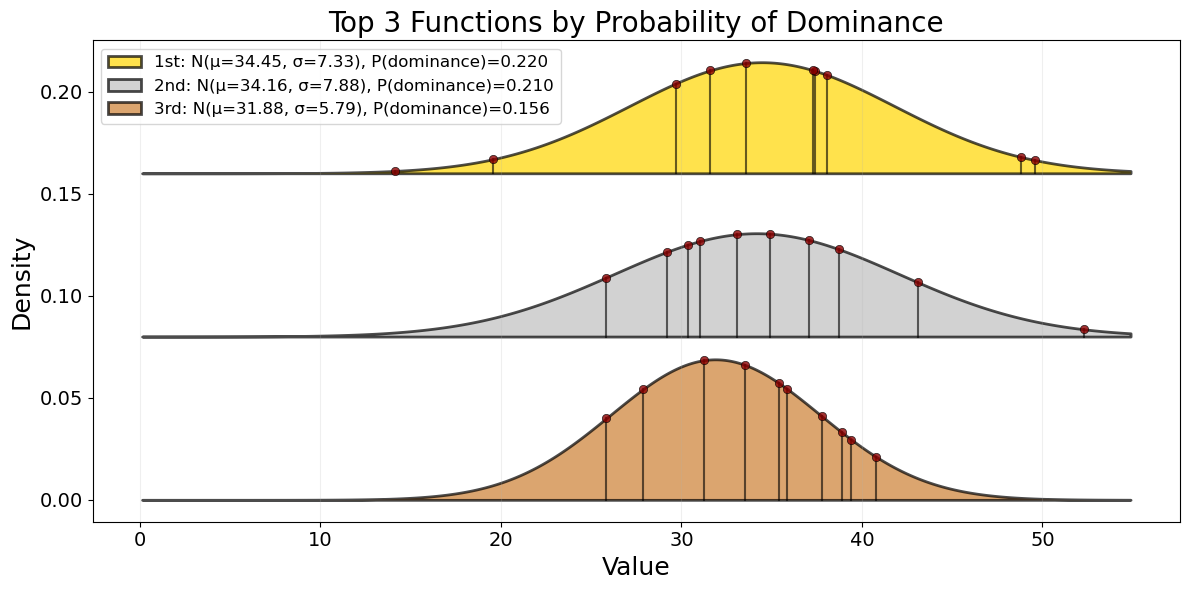

In [12]:
# Get top 3 by probability of dominance
n_plot = 3
top_3_by_prob_indices = top_indices[np.argsort(probs_dom)[-n_plot:]]

fig, ax = plt.subplots(figsize=(12, 6))

max_sigma = sigma_i.max()
x = np.linspace(mean_lower - 2 * max_sigma, mean_upper + 2 * max_sigma, 1000)
colors = ['gold', 'silver', '#CD7F32']  # Gold, Silver, Bronze
labels = ['1st', '2nd', '3rd']

# Plot in reverse order so best is on top
for rank, (idx, color, label) in enumerate(zip(reversed(top_3_by_prob_indices), colors, labels)):
    mu = mu_i[idx]
    s = sigma_i[idx]
    prob_dom = probs_dom[np.where(top_indices == idx)[0][0]]

    # Calculate vertical offset (best on top, worst on bottom)
    y_offset = (2 - rank) * 0.08

    # Generate empirical samples (use the re-estimated samples)
    local_idx = np.where(top_indices == idx)[0][0]
    samples = re_estimated_samples[local_idx]

    # Plot the true underlying Gaussian as a filled area
    y_true = norm.pdf(x, mu, s) + y_offset
    ax.fill_between(x, y_offset, y_true, alpha=0.7, color=color,
                    label=f'{label}: N(μ={mu:.2f}, σ={s:.2f}), P(dominance)={prob_dom:.3f}',
                    edgecolor='black', linewidth=2)

    # Plot sample points as vertical lines/stems from the base
    for sample in samples:
        y_sample = norm.pdf(sample, mu, s) + y_offset
        ax.plot([sample, sample], [y_offset, y_sample], color='black',
                linewidth=1.5, alpha=0.6)
        ax.plot(sample, y_sample, 'o', color='darkred', markersize=6,
                alpha=0.8, markeredgecolor='black', markeredgewidth=0.5)

ax.set_xlabel('Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.set_title(f'Top {n_plot} Functions by Probability of Dominance', fontsize=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.2, axis='x')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Note that the best function is what was previously the one with the third highest empirical mean, so the two metrics can differ. In general, the probability of dominance is a more robust metric for picking the best function as it takes into account the entire distribution of samples instead of relying on a point estimate.

There are many ways to extend or robustify this further, especially for when evaluating more functions, such as by using a cascade with more levels. We recommend practitioners to be vigilant in their cost-performance tradeoffs as allowing too much stochasticity can make seemingly good results be misleading.